In [263]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, TimeDistributed, RepeatVector, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import json
import numpy as np
import pandas as pd
import tiktoken

In [264]:
def load_dishnames():
    with open(f'../../data/storage/stage_1/recipes_df.json', 'r') as file:
        data = json.load(file)
        dishnames_df = pd.DataFrame(data)

    return dishnames_df

def load_ingredients():
    with open(f'../../data/storage/stage_1/ingredient_df.json', 'r') as file:
        data = json.load(file)
        ingredients_df = pd.DataFrame(data)

    return ingredients_df

def load_equipment():
    with open(f'../../data/storage/stage_1/equipment_df.json', 'r') as file:
        data = json.load(file)
        equipment_df = pd.DataFrame(data)

    return equipment_df

def prepare_dictionaries(dishnames_df, ingredients_df, max_ingredients=10, chr = 'i'):
    if chr == 'i':
        stop = 77
    elif chr == 'e':
        stop = 18
    dishnames_dict = dict()
    for index, row in dishnames_df.iterrows():
        # Extract the ID
        recipe_id = row['id']
        dishname = row["title"]
        # Assign the set to the corresponding ID in the dictionary
        dishnames_dict[recipe_id] = dishname

    ingredients_dict = dict()
    for index, row in ingredients_df.iterrows():
        # Extract the ID
        recipe_id = row['id']
        # Collect all non-null ingredients into a set
        # ingredients = set(value for key, value in row.items() if key.startswith('i_') and pd.notnull(value))
        ingredients = set()
        i = 1
        while (len(ingredients) < max_ingredients and i < stop):
            if pd.notnull(row[f"{chr}_{i}"]) and  " " not in row[f"{chr}_{i}"]:
                ingredients.add(row[f"{chr}_{i}"]) #add the ingredient if it is not null and does not contain a space
            i += 1
        # Assign the set to the corresponding ID in the dictionary
        ingredients_dict[recipe_id] = ingredients

    return dishnames_dict, ingredients_dict

def remove_no_ingredients(dishnames, ingredients):
    count = 0
    for id, value in list(ingredients.items()):
        if len(value) == 0:
            del dishnames[id]
            del ingredients[id]
            count += 1
    print(f"Removed {count} recipes with no ingredients")
    return dishnames, ingredients


In [265]:
encoding = tiktoken.get_encoding("cl100k_base")

def tokenize_dishnames(recipes_dict: dict):
    tokenized_dishnames = {}

    for recipe_id, dishname in recipes_dict.items():
        # Tokenize the text
        tokens = encoding.encode(dishname)

        # Store tokens in dictionary using the recipe ID as key
        tokenized_dishnames[recipe_id] = tokens
    return tokenized_dishnames

def tokenize_ingredients(recipes_dict: dict):
    tokenized_ingredients = {}

    for recipe_id, ingredients in recipes_dict.items():

        # Convert set of ingredients to a single string
        ingredients_text = ' '.join(ingredients)
        # Tokenize the text
        tokens = encoding.encode(ingredients_text)
        # Store tokens in dictionary using the recipe ID as key
        tokenized_ingredients[recipe_id] = tokens
    return tokenized_ingredients

def standardize_token_count(recipes: dict):
    max_tokens = 0
    for recipe_id, tokens in recipes.items():
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
    
    for recipe_id, tokens in recipes.items():
        if len(tokens) < max_tokens:
            for i in range(max_tokens - len(tokens)):
                tokens.append(0)
    return recipes

In [266]:
def prepare_vocab(array_of_dicts):
    vocab = set()
    for d in array_of_dicts:
        for key in d.keys():
            for token in d[key]:
                vocab.add(int(token))
    vocab = sorted(vocab)
    vocab_map = dict(enumerate(vocab))
    return vocab_map

def shrink_token(vocab_map, search_value):
    for key, value in vocab_map.items():
        if value == search_value:
            return key
    return None  # If no key is found for the given value

def expand_token(vocab_map, search_key):
    return vocab_map[search_key]

def reduce_tokens(tokenized_recipes, vocab_map):
    recipe_array = np.zeros((len(tokenized_recipes), len(tokenized_recipes[1 ])), dtype=int)

    keys = sorted(tokenized_recipes.keys())
    for i, key in enumerate(keys):
        recipe_array[i] = [shrink_token(vocab_map, token) for token in tokenized_recipes[key]]
    
    return recipe_array

In [267]:
def decode_ingredients(tokenized_ingredients, vocab_map):
    encoding = tiktoken.get_encoding("cl100k_base")
    
    expanded_tokens = [expand_token(vocab_map, token) for token in tokenized_ingredients]
    decoded_text = encoding.decode(expanded_tokens)
    decoded_text = decoded_text.replace('!', '')
    # Convert string to set of ingredients (if originally multiple ingredients)
    decoded_set = set(decoded_text.split(' '))
    
    return decoded_set

def decode_dishname(tokenized_dishname, vocab_map):
    encoding = tiktoken.get_encoding("cl100k_base")
    
    expanded_tokens = [expand_token(vocab_map, token) for token in tokenized_dishname]
    decoded_text = encoding.decode(expanded_tokens)
    decoded_text = decoded_text.replace('!', '')
    
    return decoded_text


In [268]:
def prepare_arrays(dishnames_dict, ingredients_dict, chr = 'i'):
    dishnames, ingredients = remove_no_ingredients(dishnames_dict, ingredients_dict)

    tokenized_dishnames = tokenize_dishnames(dishnames)
    tokenized_ingredients = tokenize_ingredients(ingredients)

    tokenized_dishnames = standardize_token_count(tokenized_dishnames)
    tokenized_ingredients = standardize_token_count(tokenized_ingredients)

    vocab_map = prepare_vocab([tokenized_dishnames, tokenized_ingredients])
    dishname_array = reduce_tokens(tokenized_dishnames, vocab_map)
    ingredient_array = reduce_tokens(tokenized_ingredients, vocab_map)
    
    return dishname_array, ingredient_array, vocab_map

In [269]:
def seperate_data(dishname_array, ingredient_array):
    y = np.expand_dims(ingredient_array, -1)
    X_train, X_val, y_train, y_val = train_test_split(dishname_array, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [270]:
def compile_model(dishname_array, ingredient_array, vocab_map):
    vocab_size = len(vocab_map)
    embedding_dim = 64

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=len(dishname_array[0])))
    model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(RepeatVector(len(ingredient_array[0])))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
    model.compile(optimizer=Adam(learning_rate=.02), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [271]:
def plot_model(history, type, number_of_ingredients):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss of Model predicting {number_of_ingredients} {type}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [272]:
def analyze_sample_results(model, tokenized_dishnames, dishnames_df, ingredients_dict, vocab_map, num_dishes=3, type="ingredients"):
    print("Sample Output: ")
    indices = np.random.choice(tokenized_dishnames.shape[0], size=num_dishes, replace=False)
    selected_dishes = tokenized_dishnames[indices]

    for tokenized_dishname in selected_dishes:
        # tokenized_dishname = np.array(tokenized_dishname)

        dishname = decode_dishname(tokenized_dishname, vocab_map)
        print(f"Dishname: {dishname}")

        predicted_ingredients = model.predict(tokenized_dishname.reshape(1, -1)) 
        predicted_ingredients = np.argmax(predicted_ingredients, axis=2).astype('int32')
        predicted_ingredients = decode_ingredients(predicted_ingredients[0], vocab_map)
        print(f"Predicted {type}: {predicted_ingredients}")

        recipe_id = dishnames_df[dishnames_df['title'] == dishname].iloc[0]['id']
        actual_ingredients = ingredients_dict[recipe_id]
        print(f"Actual {type}: {actual_ingredients}")
        correct = 0
        for ingredient in actual_ingredients:
            if ingredient in predicted_ingredients:
                correct += 1
        print(f"Correctly predicted {correct}/{len(actual_ingredients)} {type}\n")

# def analyze_total_output(model, tokenized_dishnames, dishnames_df, ingredients_dict, vocab_map, num_dishes=3):
#     print(f"{tokenized_dishnames.shape[0]} total dishes")
#     total_count = 0
#     correct_count = 0
#     for tokenized_dishname in tokenized_dishnames:
#         # tokenized_dishname = np.array(tokenized_dishname)

#         dishname = decode_dishname(tokenized_dishname, vocab_map)

#         predicted_ingredients = model.predict(tokenized_dishname.reshape(1, -1)) 
#         predicted_ingredients = np.argmax(predicted_ingredients, axis=2).astype('int32')
#         predicted_ingredients = decode_ingredients(predicted_ingredients[0], vocab_map)

#         filtered_df = dishnames_df[dishnames_df['title'] == dishname]
#         if not filtered_df.empty:
#             recipe_id = filtered_df.iloc[0]['id']
#             actual_ingredients = ingredients_dict[recipe_id]
#             total_count += len(actual_ingredients)
#             for ingredient in actual_ingredients:
#                 if ingredient in predicted_ingredients:
#                     correct_count += 1
#         else:
#             print(f"No match found for dishname: {dishname}")
#     print(f"Correctly predicted {correct_count}/{total_count} ingredients: {correct_count/total_count:.2f}")



def analyze(model, X_train, X_val, dishnames_df, ingredients_dict, vocab_map, num_dishes=3, type="ingredients"):
    print("------------------------------------------------")
    print("Predicting {type} from training set data: ")
    # analyze_total_output(model, X_train, dishnames_df, ingredients_dict, vocab_map, num_dishes)
    print("------------------------------------------------")
    analyze_sample_results(model, X_train, dishnames_df, ingredients_dict, vocab_map, num_dishes)

    print("\n------------------------------------------------")
    print("Predicting {type} from validation set data: ")
    # analyze_total_output(model, X_train, dishnames_df, ingredients_dict, vocab_map, num_dishes)
    print("------------------------------------------------")
    analyze_sample_results(model, X_val, dishnames_df, ingredients_dict, vocab_map, num_dishes)

In [273]:
def generate_ingredients(epox, num_ingredients, type = "ingredients"):
    dishnames_df = load_dishnames()
    if (type == "equipment"):
        chr = 'e'
        ingredients_df = load_equipment()
    else:
        chr = 'i'
        ingredients_df = load_ingredients()
    
    dishnames_dict, ingredients_dict = prepare_dictionaries(dishnames_df, ingredients_df, max_ingredients=num_ingredients, chr=chr)

    dishnames_array, ingredients_aray, vocab_map = prepare_arrays(dishnames_dict, ingredients_dict)

    X_train, X_val, y_train, y_val = seperate_data(dishnames_array, ingredients_aray)

    model = compile_model(dishnames_array, ingredients_aray, vocab_map)

    history = model.fit(X_train, y_train,
                        epochs=epox,
                        batch_size=32,
                        validation_data=(X_val, y_val))
    
    print(f"Number of {type}: {num_ingredients}")
    print(f"Vocab size: {len(vocab_map)}")
    print(f"Number of weights/biases: {model.count_params()}")
    plot_model(history, type, num_ingredients)

    analyze(model, X_train, X_val, dishnames_df, ingredients_dict, vocab_map, num_dishes=3, type=type)


Removed 21 recipes with no ingredients
Epoch 1/500
64/64 [==============================] - 4s 34ms/step - loss: 3.0896 - accuracy: 0.5853 - val_loss: 2.2686 - val_accuracy: 0.6273
Epoch 2/500
64/64 [==============================] - 2s 32ms/step - loss: 2.1273 - accuracy: 0.6200 - val_loss: 2.0786 - val_accuracy: 0.6209
Epoch 3/500
64/64 [==============================] - 2s 33ms/step - loss: 2.0114 - accuracy: 0.6204 - val_loss: 2.0195 - val_accuracy: 0.6273
Epoch 4/500
64/64 [==============================] - 2s 33ms/step - loss: 1.9763 - accuracy: 0.6211 - val_loss: 2.0184 - val_accuracy: 0.6273
Epoch 5/500
64/64 [==============================] - 2s 33ms/step - loss: 1.9536 - accuracy: 0.6219 - val_loss: 2.0193 - val_accuracy: 0.6273
Epoch 6/500
64/64 [==============================] - 2s 34ms/step - loss: 1.9216 - accuracy: 0.6217 - val_loss: 1.9846 - val_accuracy: 0.6277
Epoch 7/500
64/64 [==============================] - 2s 33ms/step - loss: 1.8874 - accuracy: 0.6214 - val_los

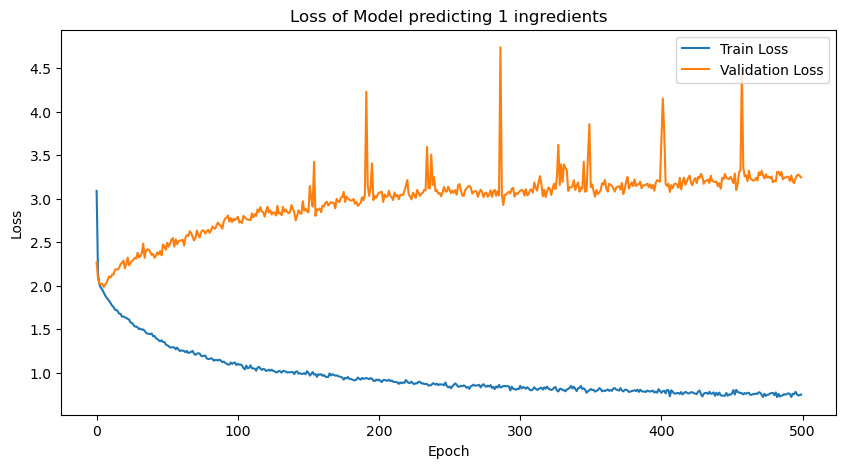

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Mahi Mahi With Onions And Mushrooms
1/1 [==============================] - 0s 186ms/step
Predicted ingredients: {'mushrooms'}
Actual ingredients: {'mushrooms'}
Correctly predicted 1/1 ingredients

Dishname: Fried Halibut Sandwich
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'mayonna'}
Actual ingredients: {'pepper'}
Correctly predicted 0/1 ingredients

Dishname: Salmon with Arugula Cream and Soy-Braised Beets
1/1 [==============================] - 0s 10ms/step
Predicted ingredients: {'vinegar'}
Actual ingredients: {'vinegar'}
Correctly predicted 1/1 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Grilled Halibut with Fennel, Tomatoes, and Roasted Garlic Rouill

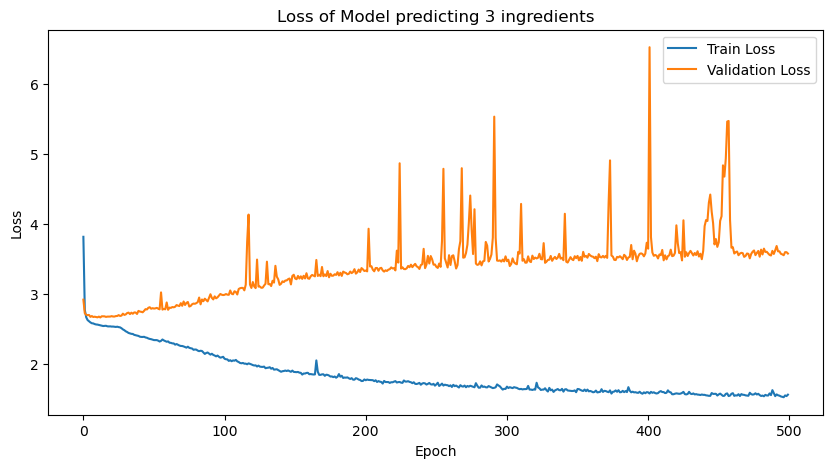

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Prosciutto, Fried Egg, and Parmesan on Country Bread
1/1 [==============================] - 0s 183ms/step
Predicted ingredients: {'prosciutto', 'butterm'}
Actual ingredients: {'butter', 'prosciutto', 'bread'}
Correctly predicted 1/3 ingredients

Dishname: Keralan Fish Curry with Lemon Rice
1/1 [==============================] - 0s 15ms/step
Predicted ingredients: {'fish', 'salter'}
Actual ingredients: {'salt', 'fish', 'turmeric'}
Correctly predicted 1/3 ingredients

Dishname: Grilled Sea Bass with Miso-Mustard Sauce
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'garlic', 'waterutter'}
Actual ingredients: {'water', 'vinegar', 'mustard'}
Correctly predicted 0/3 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
---------------------------

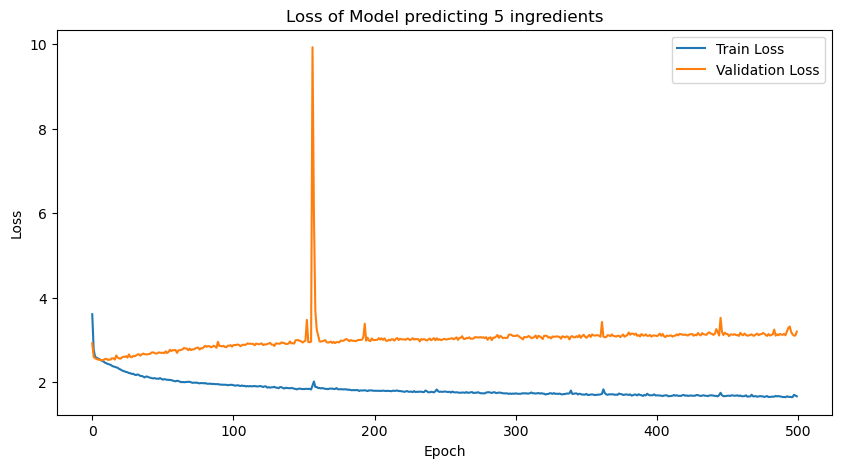

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Mustard butter, live
1/1 [==============================] - 0s 195ms/step
Predicted ingredients: {'pol', 'crutterons', 'breadff', 'may'}
Actual ingredients: {'butter', 'potato', 'cream', 'buttermilk', 'mustard'}
Correctly predicted 0/5 ingredients

Dishname: Baccala
1/1 [==============================] - 0s 14ms/step
Predicted ingredients: {'codutter', 'oregregano'}
Actual ingredients: {'butter', 'anchovies', 'onion', 'fish', 'breadcrumbs'}
Correctly predicted 0/5 ingredients

Dishname: Sear-Roasted Halibut with Blood Orange Salsa
1/1 [==============================] - 0s 13ms/step
Predicted ingredients: {'halibut', 'saucelopssp'}
Actual ingredients: {'halibut', 'salsa', 'cilantro', 'onion', 'pepper'}
Correctly predicted 1/5 ingredients


------------------------------------------------
Predicting {type} from validation s

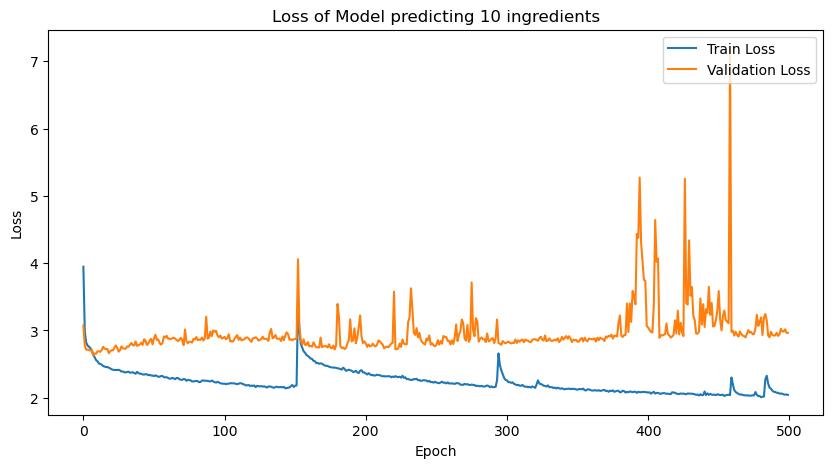

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Grilled Mahimahi with Grapefruit, Avocado, and Watercress Salad
1/1 [==============================] - 0s 200ms/step
Predicted ingredients: {'d', 'garlic', 'horseradisherc', 'par'}
Actual ingredients: {'fruit', 'watercress', 'grapefruit', 'honey', 'lime', 'salt', 'avocado', 'pepper'}
Correctly predicted 0/8 ingredients

Dishname: Sole-Wrapped Asparagus with Tangerine Beurre Blanc
1/1 [==============================] - 0s 13ms/step
Predicted ingredients: {'butter', 'parsley', 'water', 'garlic', 'salt'}
Actual ingredients: {'butter', 'wrap', 'sauce', 'water', 'asparagus', 'shallot', 'salt', 'fish'}
Correctly predicted 3/8 ingredients

Dishname: Lemon Blacken Grouper
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'butter', 'garlic', 'fish'}
Actual ingredients: {'butter', 'garlic', 'mushrooms', 'g

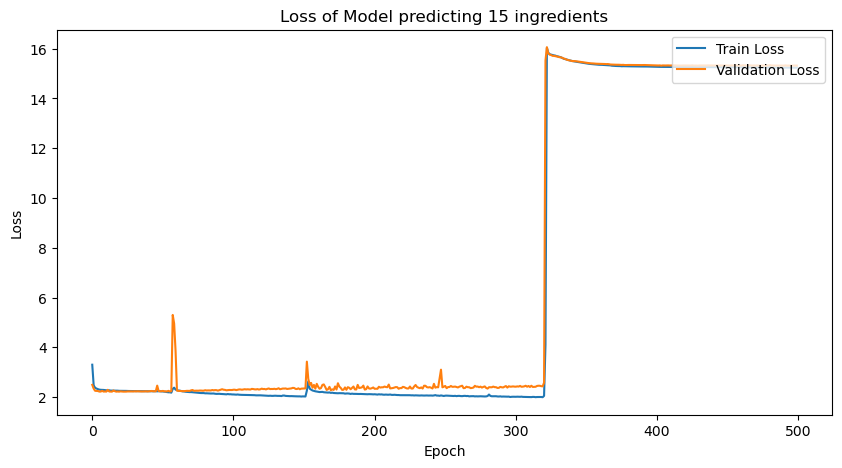

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Poached Salmon With Curried Yogurt Sauce
1/1 [==============================] - 0s 191ms/step
Predicted ingredients: {'dip', 'balsa', 'cr'}
Actual ingredients: {'yogurt', 'cilantro'}
Correctly predicted 0/2 ingredients

Dishname: Caesar Salad
1/1 [==============================] - 0s 14ms/step
Predicted ingredients: {'bfood', 'dip', 'cr'}
Actual ingredients: {'salt', 'spread'}
Correctly predicted 0/2 ingredients

Dishname: Broiled Fish With Dill Butter
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'shall', 'balsa', 'cr'}
Actual ingredients: {'butter', 'fish', 'wrap', 'dill'}
Correctly predicted 0/4 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Celery Root Ré

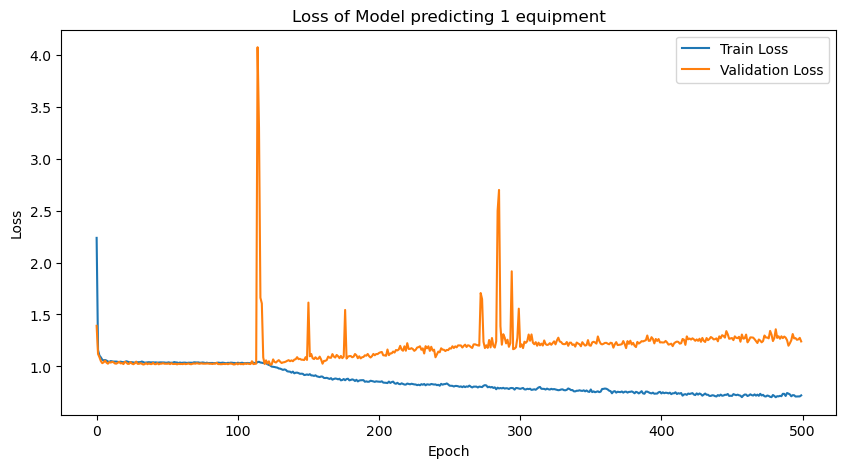

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Pan-Roasted Salmon with Tomato Vinaigrette
1/1 [==============================] - 0s 191ms/step
Predicted ingredients: {'bender'}
Actual ingredients: {'oven'}
Correctly predicted 0/1 ingredients

Dishname: Fish Veronique  (low Fat, Diabetic Friendly)
1/1 [==============================] - 0s 13ms/step
Predicted ingredients: {'oven'}
Actual ingredients: {'oven'}
Correctly predicted 1/1 ingredients

Dishname: Grilled Mahimahi with Mango Salsa
1/1 [==============================] - 0s 15ms/step
Predicted ingredients: {'b'}
Actual ingredients: {'bowl'}
Correctly predicted 0/1 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Pine Nut-crusted Pacific Salmon
1/1 [==============================] - 

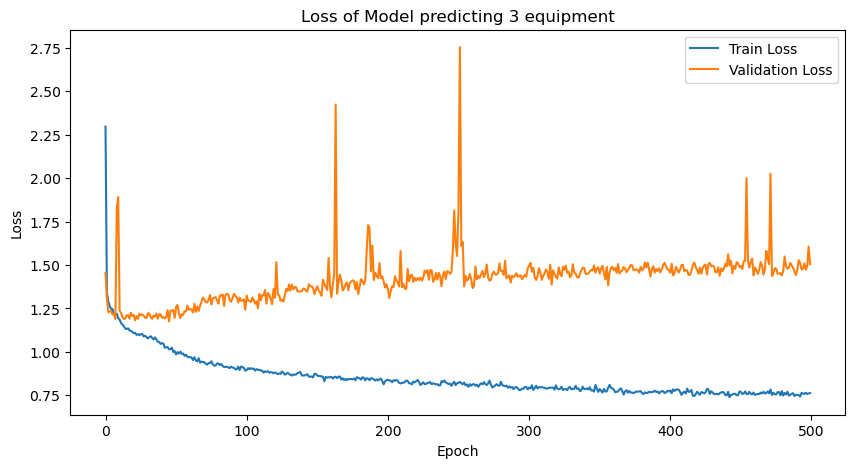

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Pan-roasted Mackerel With Sweet Potatoes
1/1 [==============================] - 0s 198ms/step
Predicted ingredients: {'bowl'}
Actual ingredients: {'spatula', 'oven'}
Correctly predicted 0/2 ingredients

Dishname: Fish-and-Chips
1/1 [==============================] - 0s 14ms/step
Predicted ingredients: {'pot'}
Actual ingredients: {'pot', 'whisk'}
Correctly predicted 1/2 ingredients

Dishname: Spring Onion Salmon In Parchment Pouches
1/1 [==============================] - 0s 11ms/step
Predicted ingredients: {'bowl'}
Actual ingredients: {'bowl', 'oven'}
Correctly predicted 1/2 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Escarole Salad with Chopped Egg and Anchovy Vinaigrette
1/1 [========

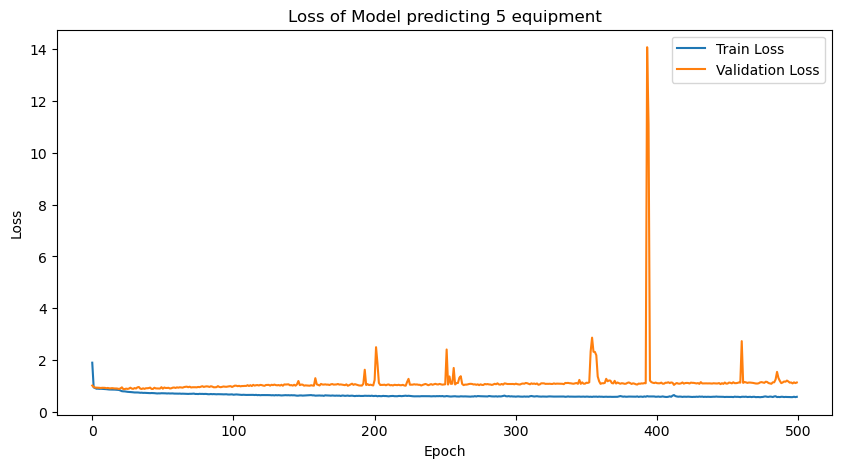

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Fisherman's Stew
1/1 [==============================] - 0s 238ms/step
Predicted ingredients: {'oven'}
Actual ingredients: {'bowl', 'pot'}
Correctly predicted 0/2 ingredients

Dishname: Shrimp-and-Smoked-Oyster Chowder
1/1 [==============================] - 0s 15ms/step
Predicted ingredients: {'bowl', 'pot'}
Actual ingredients: {'bowl', 'pot'}
Correctly predicted 2/2 ingredients

Dishname: Brazilian Seafood Soup (Moqueca)
1/1 [==============================] - 0s 13ms/step
Predicted ingredients: {'bowl', 'oven'}
Actual ingredients: {'bowl', 'ladle', 'whisk'}
Correctly predicted 1/3 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Dill Marinated Salmon With Pickled Cucumbers
1/1 [============

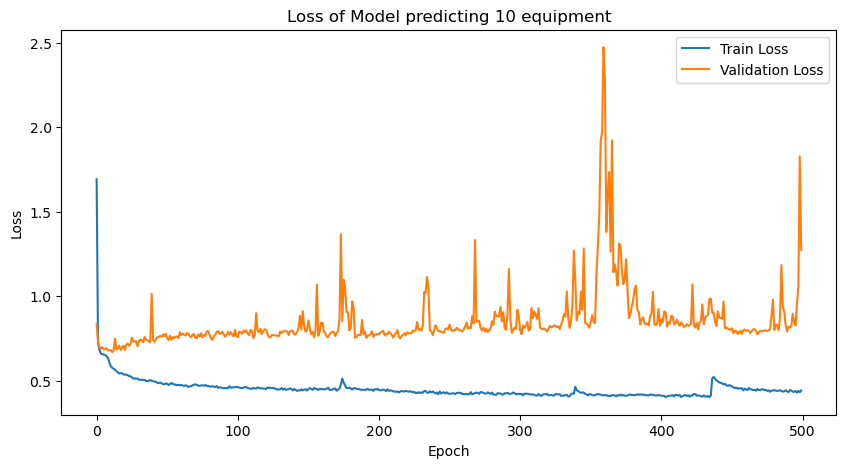

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Gravlax
1/1 [==============================] - 0s 219ms/step
Predicted ingredients: {'bowl', 'skewersanderloth'}
Actual ingredients: {'bowl', 'cheesecloth', 'sieve', 'colander'}
Correctly predicted 1/4 ingredients

Dishname: Halibut with Carrots, Fennel, Lemon, and Garlic
1/1 [==============================] - 0s 24ms/step
Predicted ingredients: {'bowl'}
Actual ingredients: {'spatula', 'blender', 'oven'}
Correctly predicted 0/3 ingredients

Dishname: Steamed Fish with Scallions and Ginger
1/1 [==============================] - 0s 17ms/step
Predicted ingredients: {'bowl', 'whiskiler'}
Actual ingredients: {'bowl', 'whisk', 'oven'}
Correctly predicted 1/3 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 

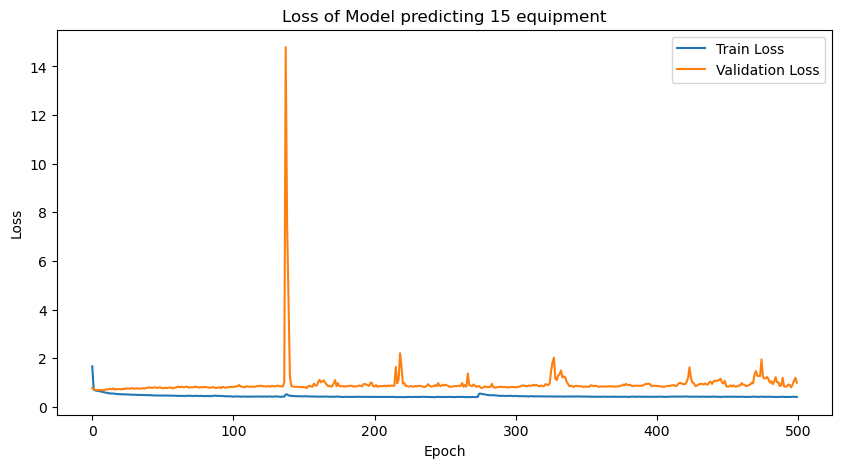

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Roasted Salmon With Cucumber Sour Cream
1/1 [==============================] - 0s 188ms/step
Predicted ingredients: {'oven'}
Actual ingredients: {'oven'}
Correctly predicted 1/1 ingredients

Dishname: Fusilli with Broccoli Rabe
1/1 [==============================] - 0s 13ms/step
Predicted ingredients: {'bowl', 'oven'}
Actual ingredients: {'bowl', 'pot'}
Correctly predicted 1/2 ingredients

Dishname: Halibut with Pepitas, Capers, Cherry Tomatoes, and Basil
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'oven'}
Actual ingredients: {'oven'}
Correctly predicted 1/1 ingredients


------------------------------------------------
Predicting {type} from validation set data: 
------------------------------------------------
Sample Output: 
Dishname: Fish Tacos
1/1 [==============================] - 0s 

In [274]:
for type in ["ingredients", "equipment"]:
    for num_ingredients in [1, 3, 5, 10, 15]:
        generate_ingredients(500, num_ingredients, type)

Removed 21 recipes with no ingredients
Epoch 1/300
64/64 [==============================] - 6s 70ms/step - loss: 2.6044 - accuracy: 0.7014 - val_loss: 1.8061 - val_accuracy: 0.7491
Epoch 2/300
64/64 [==============================] - 4s 68ms/step - loss: 1.7196 - accuracy: 0.7444 - val_loss: 1.5832 - val_accuracy: 0.7529
Epoch 3/300
64/64 [==============================] - 4s 69ms/step - loss: 1.6344 - accuracy: 0.7460 - val_loss: 1.5644 - val_accuracy: 0.7514
Epoch 4/300
64/64 [==============================] - 4s 68ms/step - loss: 1.6072 - accuracy: 0.7457 - val_loss: 1.5272 - val_accuracy: 0.7533
Epoch 5/300
64/64 [==============================] - 5s 71ms/step - loss: 1.5849 - accuracy: 0.7461 - val_loss: 1.5157 - val_accuracy: 0.7522
Epoch 6/300
64/64 [==============================] - 4s 69ms/step - loss: 1.5697 - accuracy: 0.7462 - val_loss: 1.5061 - val_accuracy: 0.7533
Epoch 7/300
64/64 [==============================] - 4s 70ms/step - loss: 1.5594 - accuracy: 0.7462 - val_los

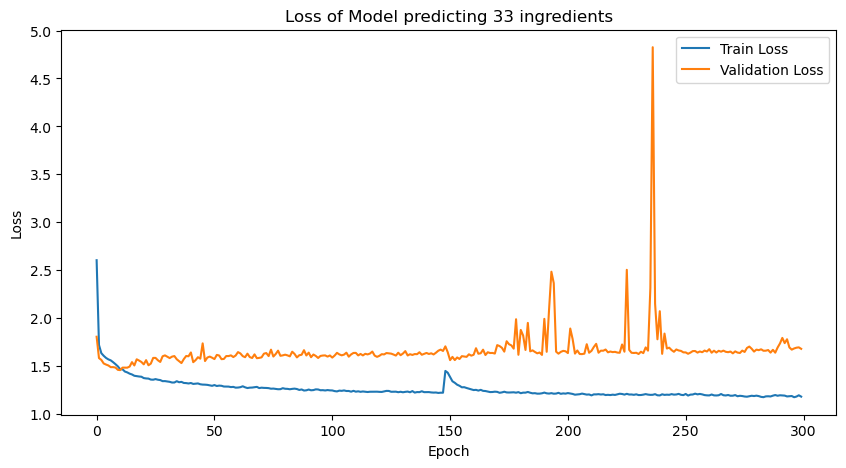

------------------------------------------------
Predicting {type} from training set data: 
------------------------------------------------
Sample Output: 
Dishname: Chopped Ceviche and Mexicola
1/1 [==============================] - 0s 181ms/step
Predicted ingredients: {'butter', 'garlic', 'seeds'}
Actual ingredients: {'oregano', 'cilantro', 'salt', 'dip', 'fish'}
Correctly predicted 0/5 ingredients

Dishname: Catalan Fish Stew with Pimentón Mayonnaise
1/1 [==============================] - 0s 15ms/step
Predicted ingredients: {'wine', 'parsley', 'water', 'garlic', 'garlicoviesovies', 'wineutter'}
Actual ingredients: {'halibut', 'mayonnaise', 'broth', 'salt', 'garlic', 'onion', 'stew', 'fish', 'olives', 'tomato'}
Correctly predicted 1/10 ingredients

Dishname: Secret Ingredient Beef Stew
1/1 [==============================] - 0s 12ms/step
Predicted ingredients: {'parsley', 'vegetable', 'water', 'garlic', 'wineutter', 'salt'}
Actual ingredients: {'wine', 'meat', 'vegetable', 'parsley',

In [279]:
generate_ingredients(300, 33, "ingredients")